In [1]:
import sys
#sys.path.remove('/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from math import isclose

from copy import deepcopy

import importlib

import time
import pickle
import random

In [2]:
import optimizor

#from optimizor import eta_2_Gamma
#from optimizor import Gamma_2_eta
#from optimizor import logdotexp

from optimizor import delta_2_eta0
from optimizor import Gamma_2_eta
from optimizor import eta0_2_delta
from optimizor import eta_2_Gamma
from optimizor import logdotexp

np.random.seed(0)
random.seed(0)

In [20]:
experiment = 1
methods = ["BFGS","SAGA"]
rand_seed = 1
partial_Es = [0,0.5,1]
optims = {}

#"experiment_1_2022-08-05_20-27-39"
#"experiment_1_2022-08-05_20-26-58"
#"experiment_1_2022-08-05_20-26-22"
#"experiment_1_2022-08-05_20-25-49"
#"experiment_1_2022-08-05_20-25-36"
#"experiment_1_2022-08-05_20-27-53"
#"experiment_1_2022-08-05_20-25-18"
#"experiment_1_2022-08-05_20-25-12"

#with open("../params/experiment_1_2022-08-05_20-25-49","rb") as f:
#    optims = pickle.load(f)
    

with open("../params/experiment_%d_control_0.0_%d" % (experiment,rand_seed),'rb') as f:
    optims["control"] = pickle.load(f)

for method in methods:
    for partial_E in partial_Es:
        if method in ["BFGS","CG"] and partial_E > 0:
            pass
        else:
            fname = "../params/experiment_%d_%s_%.1f_%d" % (experiment,method,partial_E,rand_seed)
            print(fname)
            with open(fname, 'rb') as f:
                optims[(method,partial_E)] = pickle.load(f)


../params/experiment_1_BFGS_0.0_1
../params/experiment_1_SAGA_0.0_1
../params/experiment_1_SAGA_0.5_1
../params/experiment_1_SAGA_1.0_1


In [21]:
optims

{'control': <optimizor.optimizor at 0x7fb1d2b81e50>,
 ('BFGS', 0): <optimizor.optimizor at 0x7fb1d44a7610>,
 ('SAGA', 0): <optimizor.optimizor at 0x7fb1e4e8e150>,
 ('SAGA', 0.5): <optimizor.optimizor at 0x7fb1d0c8fe50>,
 ('SAGA', 1): <optimizor.optimizor at 0x7fb1d77269d0>}

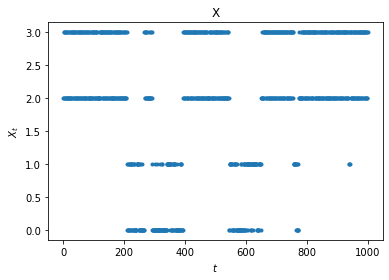

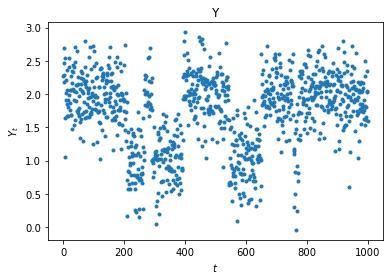

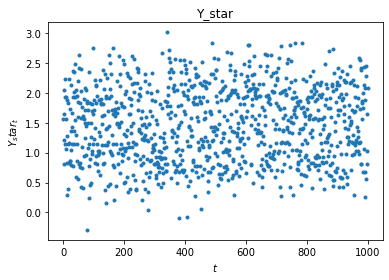

In [22]:
# plot hidden states
with open("../dat/data_X_exp-%d_T-1000"%experiment,"rb") as f:
    data_x = pickle.load(f)
plt.plot([x for x in data_x],'.')  
plt.xlabel(r"$t$")
plt.ylabel(r"$X_t$")
plt.title("X")
plt.show()

# plot data
with open("../dat/data_Y_exp-%d_T-1000"%experiment,"rb") as f:
    data_y = pickle.load(f)    
for key in data_y[0]:
    plt.plot([x[key] for x in data_y],'.')
    plt.xlabel(r"$t$")
    plt.ylabel(r"$%s_t$"%key)
    plt.title(key)
    plt.show()

# Plot Results

In [24]:
del optims["control"]

In [26]:
methods = ["BFGS","SAGA"]
experiment = 1

ll_star = -np.infty#optims["control"].log_like_trace[-1]
for key in optims:
    if ll_star < optims[key].log_like_trace[-1]:
        print("control model has lower likelihood than test model")
        ll_star = optims[key].log_like_trace[-1]

def plot_ll(optims,x_time=False):
    
    legend = []
    
    for method in methods:
        
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                if x_time:
                    plt.plot(optim.time_trace,np.log10(ll_star-optim.log_like_trace))
                else:
                    plt.plot(optim.epoch_trace,np.log10(ll_star-optim.log_like_trace))    
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$\log_{10}\left[\log p(\mathbf{y} ; \theta^*, \eta^*) - \log p(\mathbf{y} ; \theta, \eta)\right]$")
    plt.legend(legend)
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig("../plt/log-like_v_time_exp_%d.png" % experiment,dpi=500)
    else:
        plt.xlabel("Epoch")
        plt.savefig("../plt/log-like_v_epoch_exp_%d.png" % experiment,dpi=500)
    plt.show()
                
    return

def plot_results(optim,ll_star,method,partial_E,M,features,experiment=1,iters=None):
    
    title = method 
    if partial_E:
        title += ", partial E-step"
    else:
        title += ", no partial E"
    title += ", M = %dT" % M
    
    if iters is None:
        iters=len(optim.theta_trace)
        
    x = optim.epoch_trace
    
    # plot log of gradient of log-likelihood
    plt.plot(np.log10(optim.grad_norm_trace))
    plt.axhline(-3, c = 'k', linestyle = "--")
    plt.title(r"$\log_{10}$ of Gradient Norm v Epoch, %s" % title)
    plt.xlabel("Epoch (k)")
    plt.ylabel(r"$\log ||\widehat \nabla_\theta F^{(k,m)} + \widehat \nabla_\eta G^{(k,m)}||$")
    plt.savefig("../plt/grad-hat-ll-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=300)
    plt.show()

    for feature in features:
        
        # plot means
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][1][k0][feature]['mu'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\mu^{(%d,%d)}$"%(k0+1,k1+1))
        for hline in range(1,optim.K[0]):
            plt.axhline(hline, c = 'k', linestyle = "--")

        plt.title(feature + r" $\mu$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig("../plt/mu-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
        plt.show()

        # plot log(sigma)
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][1][k0][feature]['log_sig'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\log\left(\sigma^{(%d,%d)}\right)$"%(k0+1,k1+1))
        for hline in range(optim.K[0]):
            plt.axhline(hline-1, c = 'k', linestyle = "--")

        plt.title(feature + r" $\log\left(\sigma\right)$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig("../plt/log-sig-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
        plt.show()
    
    # plot eta_coarse
    legend = []
    for k in range(optim.K[0]):
        for l in range(optim.K[0]):
            if k != l:
                plt.plot(x,[optim.eta_trace[i][0][k,l] for i in range(len(optim.eta_trace))])
                legend.append(r"$\eta^{(%d,%d)}$" % (k+1,l+1))
    plt.title(r"$\eta$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/eta-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
    plt.show()
    
    # plot eta_fine
    legend = []
    for k0 in range(optim.K[0]):
        for i in range(optim.K[1]):
            for j in range(optim.K[1]):
                if i != j:
                    plt.plot(x,[optim.eta_trace[t][1][k0][i,j] for t in range(len(optim.eta_trace))])
                    legend.append(r"$\eta_%d^{*(%d,%d)}$" % (k0,i+1,j+1))
    plt.title(r"$\eta^*$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig("../plt/eta-fine-%s-%s-%d-%d.png"%(method,partial_E,M,experiment),dpi=500)
    plt.show()
    
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    #plt.title("Gradients of Standard Deviations v iteration number")
    #plt.show()

control model has lower likelihood than test model
control model has lower likelihood than test model
control model has lower likelihood than test model


/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


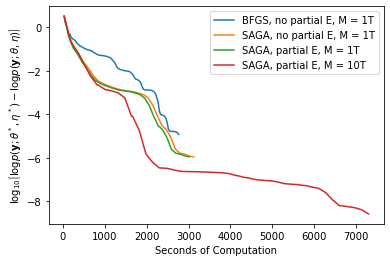

/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


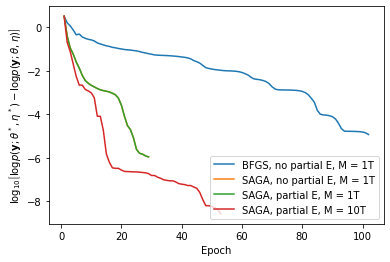

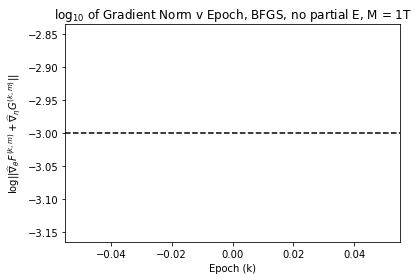

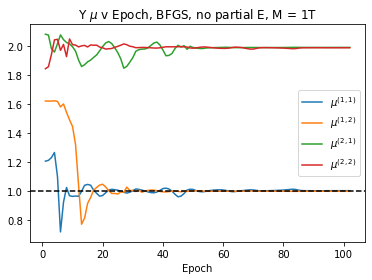

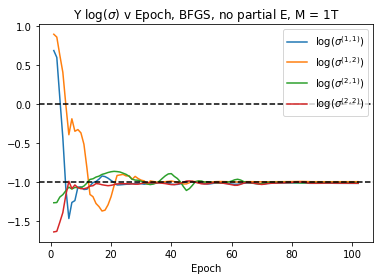

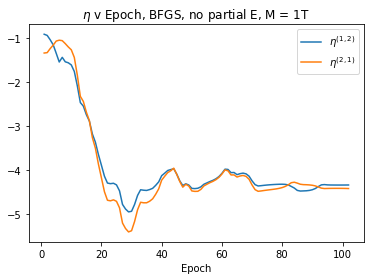

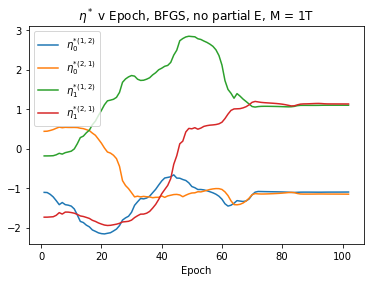

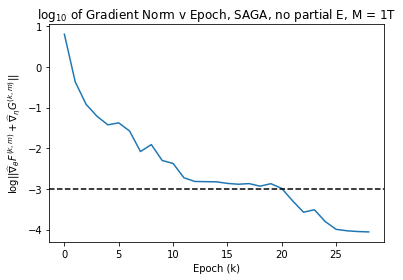

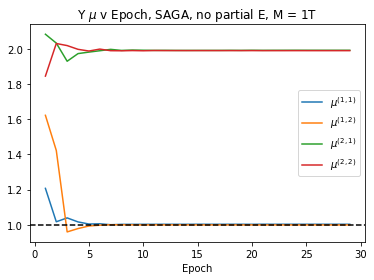

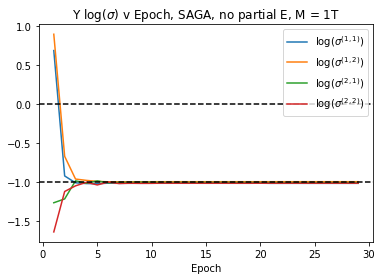

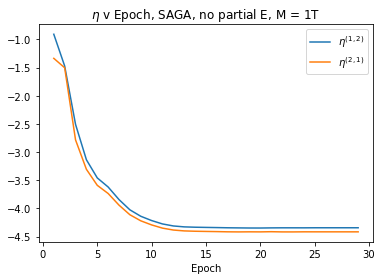

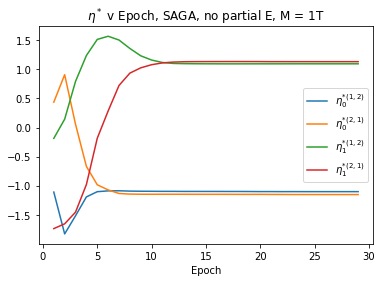

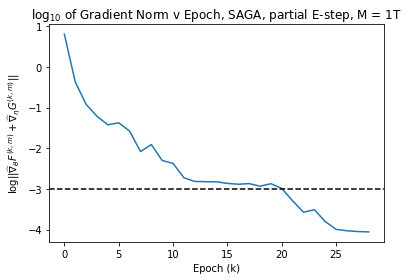

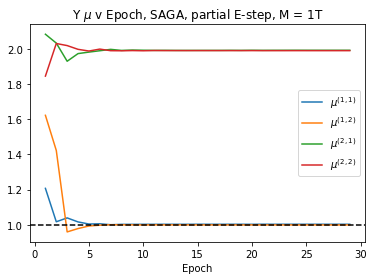

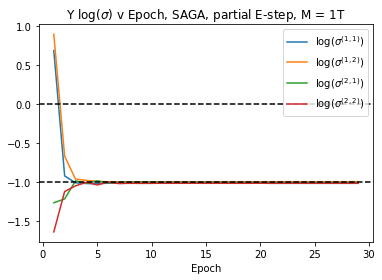

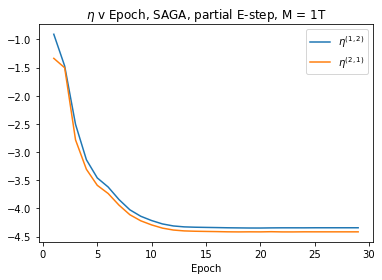

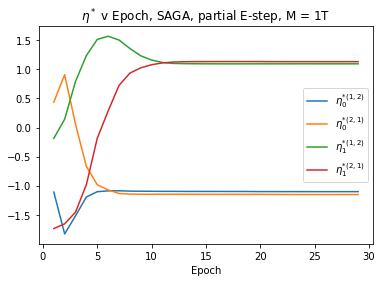

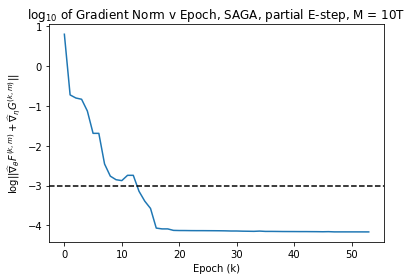

ValueError: x and y must have same first dimension, but have shapes (54,) and (9,)

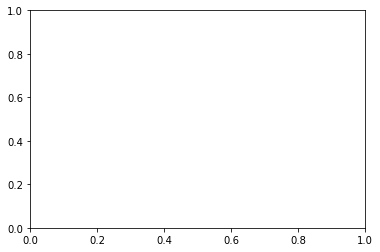

In [27]:
plot_ll(optims,x_time=True)
plot_ll(optims,x_time=False)

for method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:
    for partial_E in [0,0.5,1]:
        PE = (partial_E == 0.5) or (partial_E == 1)
        M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
        if (method,partial_E) in optims:
            plot_results(optims[(method,partial_E)],ll_star,method,PE,M,["Y"])

In [52]:
optims[("SAGA",1)].log_like_trace

[-2.258113048981349,
 -1.4358182526173529,
 -1.2297910813074042,
 -1.0981039497871408,
 -0.9963512290167209,
 -0.9623095555853147,
 -0.9623095555853147,
 -0.9513735715354512,
 -0.9477466652634238,
 -0.941544957771105,
 -0.9375700024342563,
 -0.9346508121690217]

# Check gradient accuracy

In [10]:
key = ('SAGA', 0.5)
k0 = 0
k1 = 0
param = "mu"

optims[key].E_step()

delta = 1e-8

ll_0 = optims[key].get_log_like()[0]
print(ll_0)

optims[key].theta[1][k0]["Y"][param][k1] += delta

ll_1 = optims[key].get_log_like()[0]
print(ll_1)

optims[key].theta[1][k0]["Y"][param][k1] -= delta

fd_grad = (ll_1 - ll_0) / delta

grad = optims[key].grad_theta[1][k0]["Y"][param][k1]

print(fd_grad)
print(grad)

-518.8505201744712
-518.8505201769102
-0.24390374164795503
-0.2438181789746386


In [ ]:
key = ('GD', 0)

i = 0
j = 1

optims[key].E_step()

delta = 1e-8

ll_0 = optims[key].get_log_like()[0]
print(ll_0)

optims[key].eta[0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

ll_1 = optims[key].get_log_like()[0]
print(ll_1)

optims[key].eta[0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (ll_1 - ll_0) / delta

grad = optims[key].grad_eta[0]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)
k0 = 1

i = 0
j = 1

optims[key].E_step()

delta = 1e-8

ll_0 = optims[key].get_log_like()[0]
print(ll_0)

optims[key].eta[1][k0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

ll_1 = optims[key].get_log_like()[0]
print(ll_1)

optims[key].eta[1][k0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (ll_1 - ll_0) / delta

grad = optims[key].grad_eta[1][k0]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('SAGA', 0.5)
k0 = 0
k1 = 0
param = "log_sig"
t = 0

k = k0*optims[key].K[1] + k1

optims[key].E_step()

delta = 1e-10

ll_0 = optims[key].get_log_f(t)[0][k]
#print(ll_0)

optims[key].theta[1][k0]["Y"][param][k1] += delta

ll_1 = optims[key].get_log_f(t)[0][k]
#print(ll_1)

optims[key].theta[1][k0]["Y"][param][k1] -= delta

fd_grad = (ll_1 - ll_0) / delta

grad = optims[key].get_log_f(t)[1][1][k0]["Y"][param][k1]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)
k0 = 1

i = 0
j = 1

optims[key].E_step()

delta = 1e-8

G_0 = optims[key].get_log_Gamma()[0]
print(G_0)

optims[key].eta[1][k0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = optims[key].get_log_Gamma()[0]
print(G_1)

optims[key].eta[1][k0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_log_Gamma()[2]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)

i = 0
j = 1

optims[key].E_step()

delta = 1e-8

G_0 = optims[key].get_log_Gamma()[0]
print(G_0)

optims[key].eta[0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = optims[key].get_log_Gamma()[0]
print(G_1)

optims[key].eta[0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_log_Gamma()[2]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)

i = 0
j = 1

t = 8

optims[key].E_step()

delta = 1e-8

G_0 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_0)

optims[key].eta[0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_1)

optims[key].eta[0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_grad_eta_t(t)[0][0]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)

k0 = 0

i = 1

t = 15

optims[key].E_step()

delta = 1e-4

G_0 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_0)

optims[key].eta0[1][k0][i] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_1)

optims[key].eta0[1][k0][i] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_grad_eta_t(t)[1][1][k0]

print(fd_grad)
print(grad)

#optims["control"].theta

In [ ]:
key = ('GD', 0)

i = 0
j = 1

t = 1

optims[key].E_step()

delta = 1e-8

G_0 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_0)

optims[key].eta[0][i,j] += delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

G_1 = np.sum(optims[key].p_Xtm1_Xt[t] * optims[key].get_log_Gamma()[0])
print(G_1)

optims[key].eta[0][i,j] -= delta
optims[key].log_Gamma = optims[key].get_log_Gamma(jump=False)[0]
optims[key].log_Gamma_jump = optims[key].get_log_Gamma(jump=True)[0]
optims[key].log_delta = optims[key].get_log_delta()[0]

fd_grad = (G_1 - G_0) / delta

grad = optims[key].get_grad_eta_t(t)

print(fd_grad)
print(grad)

#optims["control"].theta